#Introduction

After exploring how the evaluation metrics for both **classification** and **regression** trees work, we applied them to the students dataset not only to evaluate the efficiency of the respective trees but also to explore some ways to optimize those metrics. Although we got some decent scores — especially considering that wasn't our main goal — there are additional techniques we can use to evaluate our trees.

For the moment, we can't have full confidence in these metrics because we only used a single test subset so far — the one that train_test_split generated for us — y_test. In other words, we need to confirm if the predictions from our trees would successfully generalize to data they haven't seen before, and for that, it's clear that we need more subsets to test our Trees... a lot more!

Therefore, in this lesson we will learn how to do the following:

* Generate additional subsets to further test our decision trees.
* Determine the parameters that produce the best test scores.
* Apply two ensemble techniques that are exclusive to decision trees.

#Cross-Validation

we need to use alternate test subsets to mitigate the risk of adapting the trees in excess to the random test subset that train_test_split chose for us, which could lead to exceptionally good metrics on that subset but fail to generalize to other test subsets.

Although there are slightly different variations of how we can implement CV, here we'll use **K-fold cross-validation**, which is the default method that scikit-learn uses for cross-validation

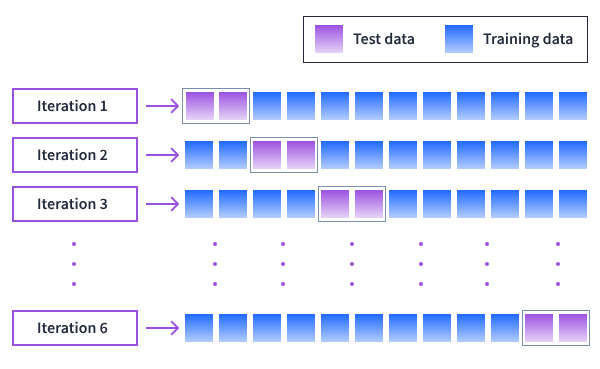

##K-Fold Cross-Validation

Let's analyze the diagram above:

We have squares, where each one represents an observation from an extremely small dataset comprised of **only 12 observations**.

We have some observations that are used as a training subset and others for a test subset, just like when we use `train_test_split`.

In this example, the dataset will be split into train and test subsets in **six different ways**. Therefore, we will have six iterations.

In each iteration, we will use different observations for the test subset, and each **subset will only be used once** during the entire process. This also applies to observations, as every observation will be used once (and only once) as well.

Here, we're using a group of two observations for the test subset in each iteration. This group is called a **fold**, and it will always include the same number of observations in each iteration. In other words, we can't have an iteration with a fold of two observations and in another iteration with a fold of three.

The number of iterations will always be equal to the number of folds since we use a different fold as a test subset during each iteration.

Finally, for each iteration, we'll get a specific score, which will depend on the training and test subsets used in that iteration.

This is the syntax to use K-fold cross-validation in scikit-learn:

    from sklearn.model_selection import cross_val_score

    tree = EitherDecisionTree() # Can use either Classification or Regression
    print(cross_val_score(tree, X, y, cv=5, n_jobs=-1))

    Output

    array([0.73076923, 0.79230769, 0.73846154, 0.74615385, 0.68992248])

There are some things to note here:

The output will be an array containing the default score for each iteration (R² for regression trees and accuracy for classification trees).

We neither fit the decision tree nor use `train_test_split` because these operations are superseded by the cross-validation process and no longer apply.

The `cv` parameter is the number of folds we want to create. The default is `5`, and in most real-life scenarios, we'll set it to between `5` and `10`.

The `n_jobs` parameter sets the number of computational processing jobs that run in parallel. In this case, -1 signals it to use all available processors.

As an additional step, it's common to calculate the mean of the scores returned by `cross_val_score`, something that is particularly helpful if the array includes scores that are very different from each other:

    print(cross_val_score(class_tree_gini,
                          X, y, cv=5,
                          n_jobs=-1).mean())

    Output
    0.7395229576624925




In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# THIS IS A REGRESSION EXERCISE.
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd

df_reg = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/students_reg.csv", sep=";")

X = df_reg.drop(["G3"], axis=1)
y = df_reg["G3"]

reg_tree_mse = DecisionTreeRegressor(criterion="squared_error", max_depth=4, random_state=24)

#Apply cross-validation to the regression tree
reg_tree_crossval = cross_val_score(reg_tree_mse, X, y, cv=5, n_jobs=-1)


crossval_mean = reg_tree_crossval.mean()

#3) Cross-Validate Tool

cross_val_score is pretty straightforward if we're using the default metrics **R²** or accuracy, but how do we proceed if we need to use a different metric for cross validation? In that case, we need to use the `scoring` parameter, which accepts a string indicating the alternate metric we want to use. You can find the available metrics (called **scorers** in this context) on this [scikit-learn page](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values), or we can get a list of them using the following code:

In [ ]:
from sklearn.metrics import get_scorer_names

print(get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'd2_absolute_error_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_max_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'neg_root_mean_squared_log_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples'

So, for instance, if we want to use a **recall** metric, we have five options: `recall`, `recall_macro`, `recall_micro`, `recall_samples`, and `recall_weighted`. These options correspond to the arguments of the average parameter for the recall function. Given that we're using a multiclass target column in the students dataset, we can't use the recall option since it only supports binary columns, so we'll use `recall_macro` instead:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

df_class = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/students_clf.csv", sep=";")

X = df_class.drop(["G3_qual"], axis=1)
y = df_class["G3_qual"]

class_tree = DecisionTreeClassifier(max_depth=4, random_state=24)

cross_val_score(
          class_tree,
          X, y, cv=5,
          scoring="recall_macro",
          n_jobs=-1)

array([0.51596256, 0.6412049 , 0.57878133, 0.6185862 , 0.54753433])

In this case, we see this model doesn't produce strong recall metrics. Since this is such a common outcome, we'll look at ways to improve these metrics in an upcoming screen when we introduce another optimization technique.



##Multiple metrics at time

Unfortunately, `cross_val_score` only accepts one metric at a time. If we want to calculate more than one metric at the same time, we need to use the complementary `cross_validate` tool, which accepts a tuple or list with all the metrics we want to use:

In [ ]:
from sklearn.model_selection import cross_validate

multiple_cross_scores = cross_validate(
                             class_tree,
                             X, y, cv=10,
                             scoring=("accuracy", "recall_macro")
                             )

print(multiple_cross_scores)

{'fit_time': array([0.01021123, 0.0079267 , 0.03004909, 0.00750494, 0.00741696,
       0.00731468, 0.00700903, 0.01272726, 0.00718212, 0.00708699]), 'score_time': array([0.00919223, 0.00811934, 0.00778747, 0.00713563, 0.00681353,
       0.00688624, 0.01439595, 0.00874662, 0.00690818, 0.01629567]), 'test_accuracy': array([0.75384615, 0.86153846, 0.73846154, 0.83076923, 0.75384615,
       0.69230769, 0.8       , 0.73846154, 0.70769231, 0.703125  ]), 'test_recall_macro': array([0.53733766, 0.67180736, 0.51094276, 0.55050505, 0.64856902,
       0.61521164, 0.71269841, 0.55340909, 0.47305195, 0.53441558])}


As we can see, in addition to our chosen metrics, it also provides `fit_time` (the time needed to fit the estimator on the train subset of each split) and `score_time` (for each split, the time needed for scoring the estimator on the test set). However, if we're only interested in the metrics, we can access them directly by selecting the **metric's name** and adding the prefix `test_`:

In [ ]:
print(multiple_cross_scores["test_accuracy"])


[0.75384615 0.86153846 0.73846154 0.83076923 0.75384615 0.69230769
 0.8        0.73846154 0.70769231 0.703125  ]


##Exercise

In [ ]:
# THIS IS A CLASSIFICATION EXERCISE.
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

df_class = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/students_clf.csv", sep=";")

X = df_class.drop(["G3_qual"], axis=1)
y = df_class["G3_qual"]

class_tree_gini = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=24)


#Apply cross-validation to the classification tree
cross_validate_prec_f1 = cross_validate(class_tree_gini, X, y, cv=10, n_jobs=-1,scoring=('precision_micro','f1_weighted'))

#Calculate the mean score for each metric
cross_validate_prec_mean = cross_validate_prec_f1['test_precision_micro'].mean()

cross_validate_f1_mean = cross_validate_prec_f1['test_f1_weighted'].mean()


#4) Make Score Tool

With respect to the scorers, there is another important aspect to consider, particularly for **regression** metrics: the scorers from `get_scorer_names`() assume that **higher** values indicate **better results** than lower values. However, when we're dealing with error metrics like the mean squared error, where a **higher value** indicates a **larger error**, this logic fails. To compensate for this, metrics that measure error are automatically transformed into **negative values** so that higher values indicate a smaller error and lower values indicate a larger error.

This is easier to understand with an example. If we have the error metrics `[0.83, 1.72, 1.25],` then 1.72 is the highest value and also the most undesirable because it's the largest error. But when we negate them, they become [`-0.83, -1.72, -1.25] `so that now -0.83 is the highest value, but at the same time it still represents the lowest error, which is what we want!

Therefore, while this transformation would apply to RMSE because it measures error, it wouldn't apply to R² because higher values for R² indicate a better result.

That said, now that we've mentioned the `RMSE`, if we want to use it with `cross-validation`, there is a problem: it doesn't appear in the list of predefined scorers! So to overcome this, we have to create a scorer for it ourselves, and for that we use the `make_scorer` tool. This would be the standard procedure:

    from sklearn.metrics import make_scorer, < the metric to customize >

    custom_scorer = make_scorer(
                      < the metric to customize >,
                      < metric's parameters to customize >,
                      < greater_is_better = False for error metrics>)


Here we assign the results of `make_scorer` to a variable, and inside it we indicate the metric we want to customize. Next, we specify the parameters we want to modify; if it's more than one, we separate them with commas. Lastly, we set the `greater_is_better` parameter to `False` if we're dealing with error metrics and leave the default (`True`) for all other metrics.

Once instantiated, we use the custom_scorer variable as the scoring parameter of cross_val_score:

    tree = DecisionTree()

    cross_val_score(tree, X, y, scoring=custom_scorer)

`make_scorer` is excellent not only for customizing our own scorers if they don't appear in the list of predefined scorers, it's also useful if we want to tweak one of those scorers with our own arguments.

##Exercise

In [ ]:
# THIS IS A REGRESSION EXERCISE.
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error,mean_squared_error
from sklearn.model_selection import cross_val_score
import pandas as pd


df_reg = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/students_reg.csv", sep=";")

X = df_reg.drop(["G3"], axis=1)
y = df_reg["G3"]

reg_tree_mse = DecisionTreeRegressor(criterion="squared_error", max_depth=4, random_state=24)

#create make score
rmse = make_scorer(root_mean_squared_error,greater_is_better = False)

#apply cross-validation with customized scorer rmse
rmse_cross_val = cross_val_score(reg_tree_mse, X, y, cv=5, n_jobs=-1,scoring=rmse,error_score='raise')

#calculate the mean of resulting scores
rmse_crossval_mean = rmse_cross_val.mean()
print(rmse_crossval_mean)

-1.4691442641817367


#5) Grid Search and Randomized Search

While the previous tool is really powerful, there is another one that uses cross-validation while also allowing us to deal with a repetitive task. As we've mentioned previously, we need to tweak our decision trees and try different parameters (and arguments) to iteratively improve the score of our models. But if we have enough computational power, we can avoid this repetitive task by using the `GridSearchCV` tool, which **allows us to exhaustively try all the possible combinations from a list of arguments for each parameter.**

To achieve this, we create a dictionary where each key is the name of a parameter and its corresponding value is a list of all the arguments that we want to try for that parameter. We then load the dictionary into our `GridSearchCV` instance, and the tool will output the best possible combination of parameters and arguments that we can then use to make predictions with the powerful model that is generated. This is the process we use:

    from sklearn.model_selection import GridSearchCV

    params = {
              "parameter1": < list of arguments to iterate >,
              "parameter2": < list of arguments to iterate >,
              "parameter3": < list of arguments to iterate >
            }

    tree = DecisionTree()

    grid_search = GridSearchCV(tree, param_grid=params)

    grid_search.fit(X, y)

While we can see every combination and their associated scores with the pd.DataFrame`(grid_search.cv_results_)` attribute, when we use `GridSearchCV`, we're interested in getting the values from the optimal combination. We can find these values via the `best_` attributes of the `GridSearchCV` instance:

    grid_search.best_params_
    grid_search.best_score_
    grid_search.best_estimator_

Here, `best_params_ `will tell us the **parameters** and their associated values that ensure an **optimal score,** which is stored in `best_score_`. As for `best_estimator_`, it's a decision tree instance which is ready to be used to make predictions on new data. So instead of having to instantiate a new tree with the optimal values from `best_params_`, we can simply use this attribute to access the optimal tree.

To summarize, below is a diagram of a typical CV workflow in model training. Thanks to `GridSearchCV`, we can automatically determine the best parameters to use when creating our decision trees.

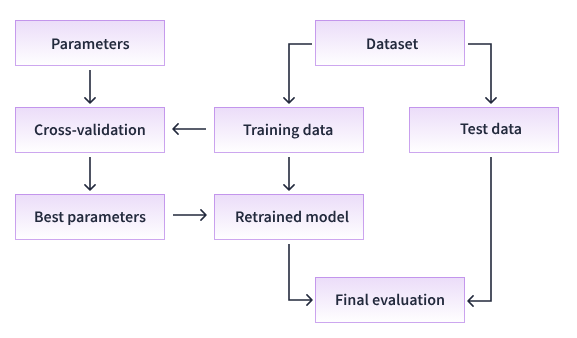



In addition, `GridSearchCV` also supports other evaluation metrics through the same scoring parameter we saw on the previous screen. It accepts the same predefined values from `get_scorer_names` and the customized scorers from `make_scorer`. Although it supports multiple metrics (by adding them to a list) it's recommended to stick with a single metric because we need to choose only one of them to get the best parameters, estimator, and score.

While `GridSearch` is an excellent tool, what happens if we don't have the time or computational power required to try every possible combination of parameters and arguments? Also, what if we can't tell which parameters have the most influence on the score? We risk losing a lot of time on unnecessary computations!

##RandomizeSearchCV

Fear not — we also have the `RandomizedSearchCV` tool, which behaves very similar to `GridSearchCV` (they even share the same parameters) except for one key difference: instead of trying every possible combination of parameters and arguments, it will only try a **random selection of possibilities in each fold.** `RandomizedSearchCV` features two new distinctive parameters:

`n_iter`: an integer to indicate how many possibilities to try in each fold. Although its default value is 10, in real-life, a more appropriate value is proportional to the total number of possible combinations.

`param_distributions`: a dictionary with the same characteristics as param_grid from `GridSearchCV`, where the key is the parameter name from the decision tree and the values are the different selected arguments for that parameter.

Which tool should we use then? It depends on a particular tradeoff: while `GridSearchCV` **tries all the possible combinations**, it requires a lot of computation time — we're taking about hours, or even an entire day! `RandomizedSearchCV` **doesn't perform exhaustive computations**, making it faster, but it's also prone to missing the optimal combination. In this sense, we need to exercise our best judgment depending on the particular situation.

Finally, consider that both tools require us to choose a sensible selection of arguments for each parameter to avoid potentially leaving out the ones that could deliver the best evaluation scores.

##Exercise

In [ ]:
# THIS IS A CLASSIFICATION EXERCISE.
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

df_class = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/students_clf.csv", sep=";")

X = df_class.drop(["G3_qual"], axis=1)
y = df_class["G3_qual"]

#dict of parameters to be evaluated
parameters = {'criterion':['gini','entropy'],
              'class_weight':[None,'balanced'],
              'min_samples_split':[12,30,48],
              'max_depth':[3,4,5,6],              'min_samples_leaf':[9,12,15,18]}

tree = DecisionTreeClassifier(random_state=24)

grid_recall = GridSearchCV(tree, param_grid=parameters,scoring="recall_macro",n_jobs=-1)

grid_recall.fit(X, y)
best_params = grid_recall.best_params_
best_estimator = grid_recall.best_estimator_
best_score = grid_recall.best_score_

print(best_params)
print(best_estimator)
print(best_score)



{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 9, 'min_samples_split': 30}
DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=9,
                       min_samples_split=30, random_state=24)
0.7337558124617758


#6) Random Forests

Throughout the remainder of this lesson, we'll focus on another powerful technique: **random forest**. This is part of the bigger family of ensemble methods where several individual machine learning models are combined to get more robust scores and predictions. The idea behind random forest is very straightforward: the individual ML models used here will be v**arious random decision trees** trained on the same dataset, and because we generate a lot of trees with this method, it's referred to as a **forest**.

It must be noted that while ensemble methods typically combine different machine learning models (i.e., logistic regression, support vector machines, decision trees, etc), **the random forest ensemble technique exclusively uses decision trees** by taking advantage of a key characteristic of trees: their sensitivity to changes in the data.

As a reminder, the different candidate thresholds for every split are decided based on the consecutive distinct observations in each column. As a consequence, minimal changes to the dataset (either to observations or columns) could end up generating completely different decision tree models.

So, because of this, random forest creates an ensemble of different trees — by altering both the observations and column selection — where the more diverse the generated trees are, the better. These alterations on the different trees are performed automatically with two specific approaches:

* **Bagging** (also known as Bootstrapping AGGregatING): with this process, random forest creates a new training subset for every new tree. The new training subset is created using a subsampling of random observations from the original dataset. This is done with replacement, which means that the same observation could be selected more than once, without limits.

##Bagging

**Bagging** (also known as Bootstrapping AGGregatING): with this process, random forest creates a new training subset for every new tree. The new training subset is created using a subsampling of random observations from the original dataset. This is done with replacement, which means that the same observation could be selected more than once, without limits.

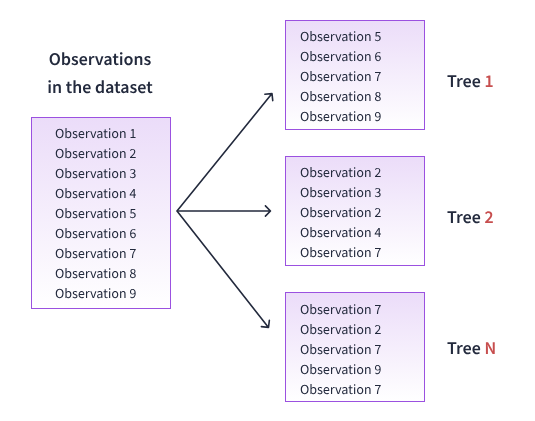

##Random Space

Random Subspace (also known as **Feature Bagging** or **Attribute Bagging**): instead of using all the feature columns, random forest will perform a random selection of them for every tree. Subsampling with replacement is used here as well.

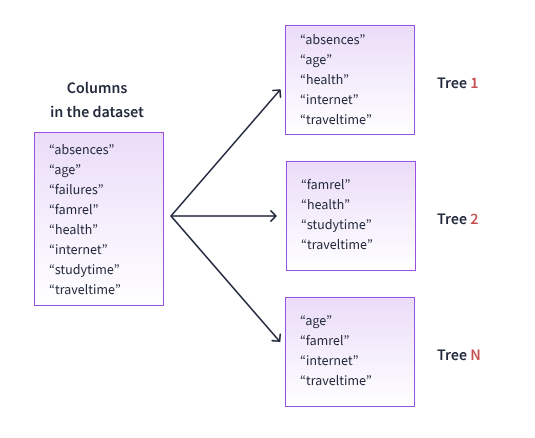

The previous approaches can be applied to a specific tree separately or combined. If they are combined, then this is referred to as **random patches**.

By applying these processes to the training subsets for the different trees, we will get a variety of splits — not only on the columns selected for each node but also for the threshold values used to perform the splits. Although this can generate some weak trees with poor predictive power, by instantiating *hundreds* or even **thousands** of trees, we will combine their strengths and mitigate their weaknesses to reach a powerful combination that decreases the tendency of individual decision trees to overfit the data.

scikit-learn includes two random forest instantiators: [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). As a reference, this is how to import, fit, and evaluate a random forest classifier:

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    random_forest = RandomForestClassifier()
    random_forest.fit(X_train, y_train)
    random_forest.score(X_test, y_test)

We can also use the `predict`() method on the model to make predictions on unseen data.

Regarding the score metrics, random forest uses the same ones as decision trees: R² for regression, and accuracy for classification. However, what these scores calculate is slightly different:

* For **regression**, the random forest score is the **mean** of all the predictions made by **every Tree**.

* For **classification**, in the `scikit-learn` implementation of the random forest technique, each decision tree under the surface** will output probabilities for each class** when making a prediction. These probabilities will then be **averaged**, and the class with the **highest average probability** will finally be selected for the specific observation. *This is different from the usual implementation of the random forest technique, where normally every tree predicts a class and then the most frequent class (the mode) among all trees is chosen.*

##Exercise


In [ ]:
# THIS IS A REGRESSION EXERCISE.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

df_reg = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/students_reg.csv", sep = ";")

X = df_reg.drop(["G3"], axis = 1)
y = df_reg["G3"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

#Instantiate a RandomForestRegressor
random_for_reg = RandomForestRegressor(max_depth=3,n_jobs=-1,random_state=32)
random_for_reg.fit(X_train, y_train)
random_regressor_score = random_for_reg.score(X_test, y_test)

print(random_regressor_score)

0.8161717547793539


#7) Random Forests Parameters

Both random forest classifier and regressor share the same parameters as decision trees: `criterion`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, `max_leaf_nodes`, `min_impurity_decrease`, `random_state`, `ccp_alpha`, and `class_weight` (exclusive to the random forest classifier, just like for classification trees). But we also have some additional parameters that are shared by both versions of random forest:

* `n_estimators`: the number of trees that our random forest will generate. The default value is `100` estimators.

* `bootstrap`: as we saw on the previous screen, random forest builds the subsets by using bootstrapping, so if we set this parameter to False, the whole dataset will be used to generate each tree instead.

* `n_jobs`: we saw this parameter during the first half of the lesson. It defines the number of computational processing jobs that run in parallel when performing all the calculations. If we want to use all the available processors, we use -1 as the argument.

* `verbose`: it's about printing logs that describe the operations that the algorithm performs in each step. Although scikit-learn doesn't specify what each number prints, the higher the integer value, the more detailed the logs will be. The default is `0`: no logs are printed.

* `warm_start`: this Boolean parameter has to do with the number of `n_estimators`. If we're using the same dataset, and we want to find the optimal number of estimators (for instance, as part of a grid search), this parameter allows us to keep some learned aspects from the previous estimator so that we can use them on the next one, saving computation time.

  For example: if we're using a grid search with `"n_estimators": [200, 300]` as possible arguments, if we set warm_start to True, then for the 300 argument, we don't need to fit 300 new trees because we can use the 200 ones that were fit for the previous argument. Therefore, by enabling this feature, we get a "warm start" and only need to fit 100 more trees.

* `max_samples`: this parameter requires that `bootstrap` is set to `True`, and it serves to specify the number of sample observations to be used to train each tree.

In addition, we have the `oob_score `parameter (**Out of Bag Score**), an alternate metric that takes the observations that were left out during bagging to use them as validation subsets, thus removing the need to use train_test_split.

We need to manually set this parameter to `True`, and it requires that the `bootstrap` parameter is set to `True` as well. This will activate the `oob_score_` attribute of the random forest instance and provide us with the OOB score. As with other scores, it will be based on the **accuracy** when using *RandomForestClassifiers* and **R²** when using *RandomForestRegressors* . In other words, the OOB score is similar to the default scores we've used so far, with the main differences being:

* How the validation set is generated.

* How we get the predictions for each observation.


##Exercise


In [2]:
# THIS IS A CLASSIFICATION EXERCISE.
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

df_class = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/students_clf.csv", sep=";")

X = df_class.drop(["G3_qual"], axis=1)
y = df_class["G3_qual"]

random_for_class = RandomForestClassifier(max_depth=3,n_jobs=-1,random_state=32,n_estimators=20,oob_score=True)

random_for_class.fit(X,y)
random_for_class_oob = random_for_class.oob_score_
print(random_for_class_oob)

0.650231124807396


#8) Random Forest - OOB Score


## Out of Bag Score for RandomForestRegressor

In this case, the averaged predictions for every observation will be stored in the attribute `oob_prediction_`, which is only available if `oob_score` is set to `True` when instantiating the *RandomForestRegressor* object. We then use this attribute in conjunction with the y variable to build `y_pred` and `y_test` columns respectively.

    oob_reg = pd.DataFrame(
                data={
                      "y_pred": random_for_reg.oob_prediction_,
                      "y_test": y}
                )
    print(oob_reg.sample(5, random_state=14))

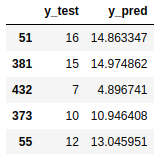

Finally, we would perform the same R² steps we saw during the previous lesson to get the OOB score:

    from sklearn.metrics import r2_score

    r2_score(y_test, y_pred)

## Out of Bag Score for RandomForestClassifier

For classification, there are additional steps we need to consider: first we extract the array of averaged predictions for each class for every observation via the `oob_decision_function_` attribute.

The order of predictions for each class will match the class order in the classes_ attribute `(['Excellent', 'Good', 'Poor', 'Sufficient', 'Very Good', 'Weak'])`, which are the possible classes in the target column of the students dataset for classification.

We then use both attributes to build a DataFrame. Here we can see the first five observations:

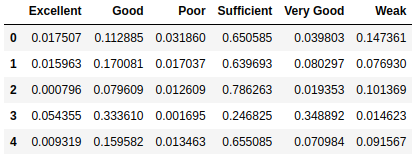

Next, in a new column that we'll call `y_pred`, we'll store the class name with the **highest** predicted probability for each observation.

Finally, we add a column `y_test` with the target values of `y`, and then we calculate the accuracy score using `y_pred` and `y_test` as usual.


In [4]:
# THIS IS THE CLASSIFICATION EXERCISE FROM PREVIOUS SCREEN.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df_class = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/students_clf.csv", sep=";")

X = df_class.drop(["G3_qual"], axis=1)
y = df_class["G3_qual"]
random_for_class = RandomForestClassifier(
                         n_estimators=20,
                         max_depth=3,
                         oob_score=True,
                         random_state=32,
                         n_jobs=-1)

random_for_class.fit(X, y)

random_for_class_oob = random_for_class.oob_score_


#Get the predictions from the oob_decision_function_
oob_predictions = random_for_class.oob_decision_function_

#get classes to match with predictions
student_classes = random_for_class.classes_

#build DataFrame . oob_predictions as data and student_classes as columns
oob_clf = pd.DataFrame(oob_predictions,columns=student_classes)

#create y_pred column
oob_clf['y_pred'] = oob_clf.idxmax(axis=1)
oob_clf['y_test'] = y

#get accuracy_score for classification
oob_accuracy = accuracy_score(oob_clf['y_test'],oob_clf['y_pred'])

answer = oob_accuracy == random_for_class_oob

print(oob_accuracy)


0.650231124807396


#Insights

The exercises from the previous screens showed us something important: despite the power of the ensemble methods, in some cases, we'll still need to tweak the hyperparameters to look for ways to improve low scores. Besides, while random forest is an incredibly powerful and useful technique, it still has a couple of considerations that we should always keep in mind:

* If a single decision tree is computationally expensive, consider that a random forest model will be training hundreds of them.

* Since we're talking about hundreds of different trees, it becomes pointless to display them since we'll be dealing with a combination of the results instead.

* Because of the previous point, the outputs will inevitably become more obscure because they will summarize the predictions of hundreds of trees. It would be incredibly difficult and time-consuming to inspect each decision tree to see how they contributed to the overall result.

* If the nature of the dataset doesn't allow random forest to create diverse trees, the results of every tree will be similar, which can negatively affect the overall score. **Remember one of the key aspects of random forest: the more diverse the generated trees are, the better!**

# 9) Extremely Randomized Trees (Extra Trees)

Now let's focus on another lesser-known variation of random forest: **extra trees**, which stands for **extremely randomized trees**. In essence, extra trees are similar to random forest, and they even have regression (ExtraTreesRegressor) and classification (ExtraTreesClassifier) instantiators.

Even more, they share the same parameters, although with different default values in some specific cases: `n_estimators`, `criterion`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, `max_leaf_nodes`, `min_impurity_decrease`, `bootstrap`, `oob_score`, `n_jobs`, `random_state`, `verbose`, `warm_start`, `ccp_alpha`, `max_samples` and `class_weight`, which is exclusive to extra trees for classification.

However, extra trees have **two** fundamental differences when compared to random forest. These differences aim to increase the level of randomness involved with extra trees:

1. **They don't use bagging**, and for this reason, the bootstrap parameter is set to False by default. This means that every tree is generated using the entire dataset.

1. Although they use a random subset of the feature columns, just like random forest, **the thresholds are decided at random**, and only the most optimal threshold of this random selection will be chosen as a split.

The code to instantiate, fit, and evaluate extra trees is similar to that for random forest. Just remember that since bootstrapping is **deactivated**, OOB score isn't available here, so we'll need to **train_test_split** our dataset.

Also, when importing the libraries, don't get confused with `ExtraTreeRegressor` or `ExtraTreeClassifier`! (notice it's tree, not trees) These are only for creating single instances of extra trees to be used in ensemble methods! We import extra trees **from sklearn.ensemble**, not sklearn.tree!

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import ExtraTreesClassifier

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    extra_clf = ExtraTreesClassifier()
    extra_clf.fit(X_train, y_train)
    extra_clf.score(X_test, y_test)

We can also use the `predict`() method on the model to make predictions on unseen data.

Consider that since extra trees are almost the same as random forest, the default scoring methods will be similar as well: **R²** for regression, and **accuracy** for classification.

In [5]:
# THIS IS A REGRESSION EXERCISE.

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

df_reg = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/students_reg.csv", sep=";")

X = df_reg.drop(["G3"], axis = 1)
y = df_reg["G3"]

#create extra trees object
extra_tree_reg= ExtraTreesRegressor(max_depth=9,n_estimators=90,random_state=32)

#create cross val score
extra_tree_crossval = cross_val_score(extra_tree_reg,X,y,cv=10,n_jobs=-1)

extra_tree_crossval_mean = extra_tree_crossval.mean()
print(extra_tree_crossval_mean)


0.7751382534561555


#10) Decision Trees — Advantages and Disadvantages

On this final screen, to provide some closure, we'll focus on the advantages and disadvantages of decision trees to summarize all that we've seen and learned.

##Decision Trees — Advantages

* Compared with the rest of machine learning algorithms, they're considerably easier to understand.

* They don't require extremely specific data wrangling in order to work, compared to other algorithms.

* They work for both classification and regression problems.

* It's possible to display them via intuitive visualizations.

* They are the best model for explaining their insights to non-technical audiences.

* They don't make assumptions about the data. For instance, linear regression assumes that data can be predicted by using a straight line. Decision trees, instead, simply aim to create homogeneous groups of observations, which doesn't require any assumptions about the underlying data.


##Decision Trees — Disadvantages

* Since they aim to create homogeneous groups of observations, and they don't stop until they do, they have a tendency to overfit the data.

* Due to the previous issue, our job isn't finished once we build and visualize the tree. We will need to spend additional time pruning the tree and tweaking the hyperparameters until we find a combination that prevents overfitting.

* Trees are extremely sensitive; a small change in the dataset can greatly alter the thresholds and generate totally different splits. But remember that **both random forest and extra trees take advantage of this weakness**!

* Due to the time spent finding the optimal thresholds — an iterative process — trees can be computationally intensive when we're using a large dataset.

* Although they can be relatively easy to understand on the surface, if we want a deeper understanding, we've seen how their calculations can become complex and repetitive.

Despite these limitations, always remember that decision trees represent one of the most popular and effective machine learning algorithms still in use today.

In [6]:
# THIS IS A CLASSIFICATION EXERCISE.
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

df_class = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/students_clf.csv", sep = ";")

X = df_class.drop(["G3_qual"], axis = 1)
y = df_class["G3_qual"]

#random forest object
weak_forest_class = RandomForestClassifier(oob_score=True,random_state=32)

#parameters dict for search
parameters = {'max_depth':[9,10,11],
              'n_estimators': [80,100]}

#create GridSearchCV instance
grid_random_class = GridSearchCV(weak_forest_class,param_grid=parameters,n_jobs=-1)

grid_random_class.fit(X,y)

#get the best parameters
grid_random_class_params = grid_random_class.best_params_

#get best score
grid_random_class_score = grid_random_class.best_score_

#get best oob_score_ from best_estimator_
grid_random_class_oob = grid_random_class.best_estimator_.oob_score_

print(grid_random_class_params)
print(grid_random_class_score)
print(grid_random_class_oob)

{'max_depth': 10, 'n_estimators': 80}
0.7410852713178294
0.7550077041602465
